In [104]:
## importing necessary dependencies 
## Note - Some dependencies may be redundant and not really required in this notebook. 
import obspy 
from obspy.geodetics.base import gps2dist_azimuth
from obspy.taup import TauPyModel


import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

### The purpose of this notebook is - 

1) Compute the SNR of all the available waveforms at all the 15 stations considered in this study

2) SNR is computed using the formula  = max(abs(signal))/ std(entire waveform) 

3) Each waveform that we have of icequakes  and earthquakes at each station is of 5 minutes in duration since the origin time given in the USGS event catalog

4) Since the sampling rate at each station is 50 Hz, each waveform at each station contains 15000 samples. 

5) After computing the SNR of all the waveforms at all the stations, it is a good idea to write them and store them in disk. It takes hours to compute the SNR and therefore by saving them on the dist we simply have to reload them instead of computing every single time we need them. 

6) For each station, we will train our model with the waveforms having SNR > median(all the SNRs) and then test the model with the waveforms having SNR <= mdeian(all the SNRs)

7) We will compare the model performance obtained using step 6 with the model performance by randomly splitting the data with test:train 3:7



### Naming convention of waveforms

1) I have named the downloaded icequakes and earthquakes for each station in a very specific way that helps me in processing. 

2) A typical icequake waveform is named icequake(its number on catalog)_(station name).mseed

For example - icequake which appears at 244th in the USGS event catalog and recorded at stationn "SCM" will be named as icequake244_SCM.mseed

3) Same naming convention applies for the earthquake waveforms

### Defining some useful functions that will be used in the rest of the notebook

In [177]:
def compute_snr(station, l=0):
    """"
    
    This function will compute the SNR of each waveform at a given station and stored it in an array 
    
    :station = station name
    :l = [0,1,2] for [E,N,Z]

    
    """
    

    snr = []    ## container where SNRs will be stored. 
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])[l] # loading the waveform whose SNR is to be computed
        string = glob('Data/icequake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:

            index = int(string.split('/')[2].split('icequake')[1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
    
            val = pd.read_csv('icequakes_catalog.csv').values[index]
            time, lat, lon, depth = val[0], val[1], val[2], val[3]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            model = TauPyModel(model="iasp91")
            dist = gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(111*1000)
            arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=dist)
            arr = arrivals[0]
            
            # We are computing the max(abs(signal)) as the maximum value in the one minute duration after the arrival time
            # The arrival time is computed using Obspy taup 
            
            snr.append(max(abs(st[int(arr.time*st.stats.sampling_rate):int(arr.time*st.stats.sampling_rate+60)]))/np.std(st.data))
            

    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])[l]
        if len(st.data) == 15000:
            index = int(string.split('/')[2].split('icequake')[1].split('_')[0])
            val = pd.read_csv('earthquakes_catalog.csv').values[index]
            time, lat, lon, depth = val[0], val[1], val[2], val[3]
            stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            model = TauPyModel(model="iasp91")
            dist = gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(111*1000)
            arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=dist)
            arr = arrivals[0]
            snr.append(max(abs(st[int(arr.time*st.stats.sampling_rate):int(arr.time*st.stats.sampling_rate+60)]))/np.std(st.data))
            
   
    

    return snr    


def forest_test(X, Y, n_estimators= 50):
    """"
    This function applies random forest and computes the accuracy
    
    :param X = features matrix
    :param Y = labels matrix
    :param n_estimators = no. of trees in random forests.
    
    """
    
    
    
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc

In [119]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stations = stns.values[:,1].astype('str')
stations

array(['BAE', 'BAT', 'BAW', 'EYAK', 'FID', 'GLI', 'HIN', 'KLU', 'KNK',
       'M23K', 'PS12', 'PWL', 'SAW', 'SCM', 'VMT'],
      dtype='<U4')

In [121]:
for i in range(len(stations)): 
    snr = compute_snr(stations[i])
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/SNR_waveforms/"+stations[i]+".txt", snr)

 13%|█████████████████████▊                                                                                                                                             | 374/2795 [01:50<11:45,  3.43it/s]/tmp/ipykernel_3384113/2619540705.py:46: RuntimeWarning: divide by zero encountered in true_divide
  snr.append(max(abs(st[int(arr.time*st.stats.sampling_rate):int(arr.time*st.stats.sampling_rate+60)]))/np.std(st.data))
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2506/2795 [12:23<01:33,  3.08it/s]/tmp/ipykernel_3384113/2619540705.py:46: RuntimeWarning: divide by zero encountered in true_divide
  snr.append(max(abs(st[int(arr.time*st.stats.sampling_rate):int(arr.time*st.stats.sampling_rate+60)]))/np.std(st.data))
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [167]:
accuracy_snr = []
for i in tqdm(range(len(stations))): 
        snr = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/SNR_waveforms/"+stations[i]+".txt")
        index_bigger_snr = np.where(snr > np.median(snr))[0]
        index_lower_snr = np.where(snr <= np.median(snr))[0]
        X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+station+".txt")
        y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+station+"_labels.txt")        
        X_train, y_train = X[index_bigger_snr], y[index_bigger_snr]
        X_test, y_test = X[index_lower_snr], y[index_lower_snr]  
        trainedforest = RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
        predictionforest = trainedforest.predict(X_test)
        acc = accuracy_score(y_test, predictionforest)         
        accuracy_snr.append(acc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [16:44<00:00, 66.98s/it]


In [169]:
accuracy_snr

[1.0,
 1.0,
 1.0,
 0.94821887623944179,
 0.91330953595104536,
 0.9470092332396628,
 0.93846780766096172,
 0.94276629570747217,
 0.94697254606995107,
 1.0,
 1.0,
 0.94401168451801365,
 0.93969091594421406,
 0.82106413994169092,
 1.0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


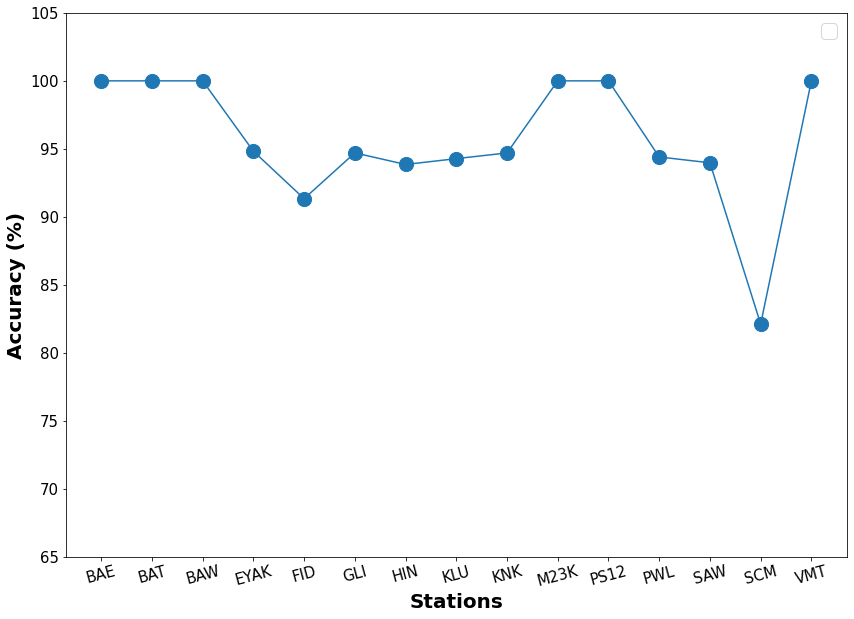

In [176]:
fig, ax = plt.subplots(1,1,figsize=[14,10])
x = np.arange(len(stations))
ax.scatter(x, np.array(accuracy_snr)*100, s=200)
ax.plot(x, np.array(accuracy_snr)*100)
ax.set_ylim(65, 105)
ax.set_xlabel('Stations', fontsize=20, weight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=20, weight='bold')
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(labels=stations, rotation=15, size=15)
ax.legend(ncol=4, fontsize=20)

In [178]:
starttime = time.time()
acc_spectrum = []
for i in tqdm(range(len(stations))):
    X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+".txt")
    y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt")
#    X = np.reshape(X[~np.isnan(X)],[len(y),round(np.shape(X[~np.isnan(X)])[0]/len(y))])  # Assuming each row contains equal number of NaN values
#    X = np.delete(X, np.unique(np.where(np.isnan(X))[1]), axis=1)
    acc_spectrum.append(forest_test(X,y))
endtime = time.time()

print("Total time taken:", endtime-starttime)    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [13:20<00:00, 53.37s/it]

Total time taken: 800.5709598064423


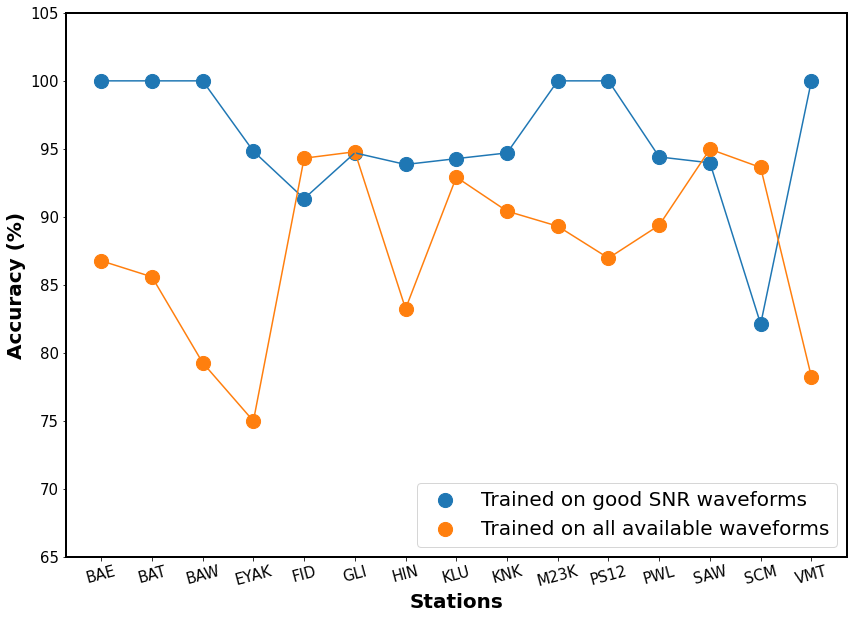

In [250]:
plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots(1,1,figsize=[14,10], facecolor='white')
x = np.arange(len(stations))
ax.scatter(x, np.array(accuracy_snr)*100, s=200, label = "Trained on good SNR waveforms")
ax.plot(x, np.array(accuracy_snr)*100)

ax.scatter(x, np.array(acc_spectrum)*100, s=200, label = "Trained on all available waveforms")
ax.plot(x, np.array(acc_spectrum)*100)

ax.set_ylim(65, 105)
ax.set_xlabel('Stations', fontsize=20, weight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=20, weight='bold')
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(labels=stations, rotation=15, size=15)
ax.legend(loc = "lower right", ncol=1, fontsize=20)

In [224]:
icequakes_in_training = []
earthquakes_in_training = []

icequakes_in_test = []
earthquakes_in_test = []

for i in tqdm(range(len(stations))):
        y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt")
        snr = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/SNR_waveforms/"+stations[i]+".txt")

        bigger_snr = np.where(snr > np.median(snr))[0]
        lower_snr = np.where(snr <= np.median(snr))[0]
        ice_index  = np.where(y == 1)[0][-1]

        icequakes_in_training.append(len(np.where(bigger_snr <= ice_index)[0]))
        earthquakes_in_training.append(len(np.where(bigger_snr > ice_index)[0]))

        icequakes_in_test.append(len(np.where(lower_snr <= ice_index)[0]))
        earthquakes_in_test.append(len(np.where(lower_snr > ice_index)[0]))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 52.41it/s]


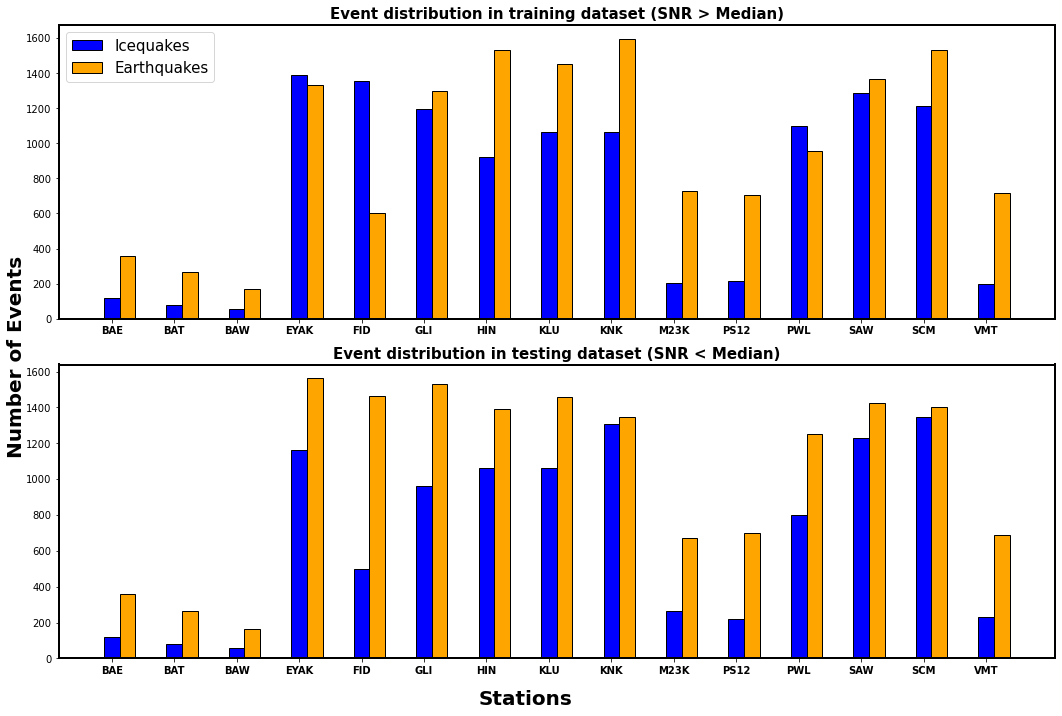

In [249]:
n = 15
r  = np.arange(n)
width = 0.25

fig, ax = plt.subplots(nrows = 2, ncols =1, figsize = [15,10], facecolor='white')

ax[0].bar(r,icequakes_in_training, color='b', width = 0.25, edgecolor='black', label = 'Icequakes')
ax[0].bar(r+width,earthquakes_in_training, color='orange', width = 0.25, edgecolor='black', label = 'Earthquakes')

ax[1].bar(r,icequakes_in_test, color='b', width = 0.25, edgecolor='black', label = 'Icequakes')
ax[1].bar(r+width,earthquakes_in_test, color='orange', width = 0.25, edgecolor='black', label = 'Earthquakes')

ax[0].set_xticks(r)
ax[0].set_xticklabels(stations, fontweight='bold', fontsize=10)
ax[0].set_title('Event distribution in training dataset (SNR > Median)', fontsize=15, fontweight= 'bold')
ax[0].legend(fontsize=15)

ax[1].set_xticks(r)
ax[1].set_title('Event distribution in testing dataset (SNR < Median)', fontsize = 15, fontweight = 'bold')
ax[1].set_xticklabels(stations, fontweight='bold', fontsize=10, )


fig.supylabel("Number of Events", fontsize=20, fontweight = 'bold')
fig.supxlabel("Stations", fontsize=20, fontweight = 'bold')
plt.tight_layout()